###  앙상블 학습

* 앙상블 학습의 유형은 보팅, 배깅, 부스팅 세가지로 나눌 수 있으며 이외에도 스태깅을 포함한 다양한 앙상블 방법이 있다.
* 보팅의 경우 서로 다른 알고리즘을 가진 분류기를 결합하는 것이고 배깅의 경우 각각의 분류기각 모두 같은 유형의 알고리즘 기반이다.
* 정형 데이터의 예측 분석 영역에서는 매우 높은 예측 성능. Bagging 과 Boosting
* 배깅 방식의 대표인 Random Forest는 뛰어난 예측 성능, 상대적으로 빠른 수행시간, 유연성 등으로 애용.
* 부스팅의 효시는 Gradient Boosting, 한 단계 발전시키면서도 시간 단축시킨 XgBoost, LightGBM이 정형 데이터의 분류 영역에서 
  활용도 확대
* 앙상블의 앙상블이라고 불리는 스태킹 기법
* 앙상블의 기본 알고리즘은 결정 트리


#### Voting Classifier
- 하드 보팅(Hard Voting): 다수결 원칙, 다수의 분류기가 결정한 예측값을 최종 보팅 결과값으로 선정
- 소프트 보팅(Soft Voting): 분류기들의 레이블 값 결정 확률을 모두 더해서 평균을 낸 후  
이들 중 가장 높은 레이블 값을 최종 보팅 결과값으로 선정

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

cancer = load_breast_cancer()
lr = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors = 9) # k(이웃)값은 홀수로 넣어주기!
vo = VotingClassifier(estimators=[('LR',lr),('KNN',knn)], voting='soft')
# estimators는 분류기. 객체 선언한 거 넣고 보팅 방식(하드/소프트) 구분하여 선언

In [2]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                   test_size=0.2, random_state=156)
vo.fit(X_train, y_train)
pred = vo.predict(X_test)
print(f'Soft Voting 분류기 정확도: {accuracy_score(y_test, pred):.4f}')

Soft Voting 분류기 정확도: 0.9474


In [3]:
classifier = [lr, knn]

for i in classifier:
    i.fit(X_train, y_train)
    pred = i.predict(X_test)
    class_name = i.__class__.__name__
    print(f'{class_name} 분류기 정확도: {accuracy_score(y_test, pred):.4f}')

LogisticRegression 분류기 정확도: 0.9386
KNeighborsClassifier 분류기 정확도: 0.9649


### Random Forest


https://eunsukimme.github.io/ml/2019/11/26/Random-Forest/

In [4]:
feature_names_df = pd.read_csv('./dataset/human_activity/features.txt',
                              sep='\s+', header=None, names=['column_index','column_name'])

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                 columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index() 
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(),feature_dup_df,how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name',
                                                             'dup_cnt']].apply(lambda x:x[0]+'_'+str(x[1])
                                                                              if x[1]>0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'],axis=1)
    return new_feature_name_df

def get_human_dataset():
    feature_names_df = pd.read_csv('./dataset/human_activity/features.txt',
                              sep='\s+', header=None, names=['column_index','column_name'])
    feature_name = feature_names_df.iloc[:,1].values.tolist()
    new_feature_name_df = get_new_feature_name_df(feature_names_df)
    
    X_train = pd.read_csv('./dataset/human_activity/train/X_train.txt',
                          sep='\s+',header=None)
    X_train.columns = feature_name
    X_test = pd.read_csv('./dataset/human_activity/test/X_test.txt',
                          sep='\s+',header=None)
    X_test.columns = feature_name
    y_train = pd.read_csv('./dataset/human_activity/train/y_train.txt',
                          sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./dataset/human_activity/test/y_test.txt',
                          sep='\s+',header=None,names=['action'])
    
    return X_train, X_test, y_train, y_test

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

In [6]:
# 밑에 건 나무를 많이 심어서 뽑아내는 거라 좀 오래 걸림 ㅎㅎ...

In [7]:
X_train, X_test, y_train, y_test = get_human_dataset()

rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
print(f'{rf.__class__.__name__} 분류기 정확도: {accuracy_score(y_test,pred):.4f}')

RandomForestClassifier 분류기 정확도: 0.9253


In [8]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators':[50,100],
         'max_depth': [2,3,5],
         'min_samples_leaf':[1,2,3],
         'min_samples_split':[2,3,5]}

# rf로 객체 생성한 후 GridSearchCV 수행
rf = RandomForestClassifier(random_state=4)
grid = GridSearchCV(rf, param_grid=params, cv=3, refit=True)
grid.fit(X_train, y_train)

print(f'{grid.__class__.__name__} 최적 파라미터: {grid.best_params_}')
print(f'{grid.__class__.__name__} 최고 정확도: {grid.best_score_:.4f}')

GridSearchCV 최적 파라미터: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
GridSearchCV 최고 정확도: 0.9072


In [10]:
y_pred = grid.best_estimator_.predict(X_test)
accuracy_test = accuracy_score(y_test , y_pred)
print('테스트 데이터에서 정확도: {0:.3f}'.format(accuracy_test))

테스트 데이터에서 정확도: 0.895


In [9]:
# 믿을조 풀이
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[50, 100],
    'max_depth' : [6, 8, 10, 12], 
    'min_samples_leaf' : [5, 8, 12, 18],
    'min_samples_split' : [5, 8, 16, 20]
}
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)

# n_jobs를 -1로 주면 모든 cpu를 통해 연산. 조금 빨라진다
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=2, n_jobs=-1 )
grid_cv.fit(X_train , y_train)
accuracy_train = grid_cv.best_score_

y_pred = grid_cv.best_estimator_.predict(X_test)
accuracy_test = accuracy_score(y_test , y_pred)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('트레인 데이터 최고 예측 정확도: {0:.3f}'.format(accuracy_train))
print('테스트 데이터에서 정확도: {0:.3f}'.format(accuracy_test))


최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 100}
트레인 데이터 최고 예측 정확도: 0.918
테스트 데이터에서 정확도: 0.920


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

rf1 = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=8,
                            min_samples_split=5, random_state=0)
rf1.fit(X_train, y_train)

importance = rf1.feature_importances_
fea_impo = pd.Series(importance, index=X_train.columns)
top20 = fea_impo.sort_values(ascending=False)[:20]

In [18]:
fea_impo[:10]

tBodyAcc-mean()-X    0.000068
tBodyAcc-mean()-Y    0.000208
tBodyAcc-mean()-Z    0.000089
tBodyAcc-std()-X     0.006275
tBodyAcc-std()-Y     0.000157
tBodyAcc-std()-Z     0.000158
tBodyAcc-mad()-X     0.003624
tBodyAcc-mad()-Y     0.000300
tBodyAcc-mad()-Z     0.000188
tBodyAcc-max()-X     0.012114
dtype: float64

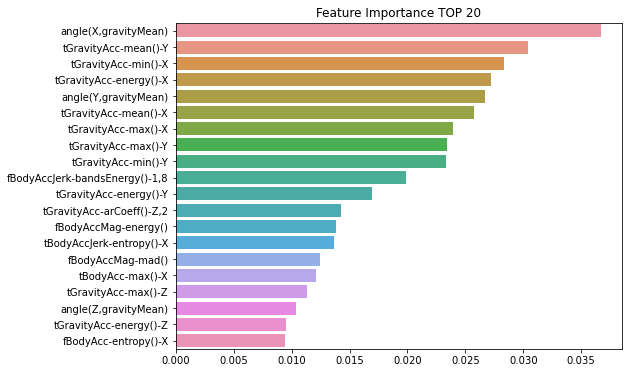

In [14]:
plt.figure(figsize=(8,6))
plt.title('Feature Importance TOP 20')
sns.barplot(x = top20, y = top20.index)
plt.show()

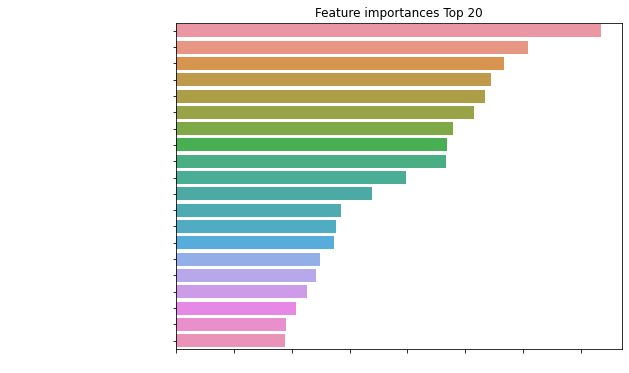

In [19]:
# 믿을조 풀이
import seaborn as sns
import matplotlib.pyplot as plt

ftr_importances_values = grid_cv.best_estimator_.feature_importances_

# Series변환 후 중요도값 순으로 Series를 정렬
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

## 다크모드여서 흰색으로 표시
[t.set_color('white') for t in ax.xaxis.get_ticklabels()]
[t.set_color('white') for t in ax.yaxis.get_ticklabels()]
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
##
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()


### GBM(Gradient Boosting Machine)
- 부스팅 알고리즘은 여러 개의 약한 학습기(weak learner)를 순차적으로 학습-예측하면서 잘못 예측한 데이터에 가중치 부여를 통해 오류를 개선해 나가면서 학습하는 방식
- 가중치 업데이트를 경사 하강법(Gradient Descent)를 이용한다.
- 분류는 물론이고 회귀도 가능
- 파라미터 : n_estimators, max_depth, max_features
 - loss : 경사하강법에서 사용할 비용함수 지정. 기본값 deviance 적용
 - learning_rate : GBM이 학습할 때마다 적용할 학습률.오류값 보정 시 적용하는 계수로 0 ~ 1 사이의 값 지정. 기본값은 0.1. 작게 설정하면 예측성능이 높아지나 수행시간이 오래 걸리고 큰 값을 적용하면 예측 성능이 떨어질 가능성이 높으나 빠른 수행이 가능. n_estimator와 상호 보완적으로 조합해 사용
 - n_estimator : weak learner의 개수
 - subsample : weak learner가 학습에 사용하는 데이터의 샘플링 비율. 기본값은 1


In [21]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics  import accuracy_score
import time

X_train, X_test, y_train, y_test = get_human_dataset()
start_time = time.time()

gb = GradientBoostingClassifier(random_state=0)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print(f'GBM 정확도: {gb_accuracy:.4f}')
print(f'작업 소요시간: {(time.time()-start_time):.2}초')

GBM 정확도: 0.9389
작업 소요시간: 4.8e+02초


In [ ]:
# [과제] 상기 케이스에 대하여 성능 개선을 위한 튜닝 진행 (GridSearchCV, 약 1시간 걸림)
# 테스트 데이터에 대해서도 작업하기

In [23]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators':[100,500],
         'learning_rate':[0.05, 0.1]}
grid = GridSearchCV(gb, param_grid=params, cv=2, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


TypeError: unsupported format string passed to dict.__format__

In [25]:
print(f'최적 하이퍼 파라미터: {grid.best_params_}')
print(f'최적 하이퍼 파라미터: {grid.best_score_:.4f}')

최적 하이퍼 파라미터: {'learning_rate': 0.05, 'n_estimators': 500}
최적 하이퍼 파라미터: 0.9002


In [26]:
# 테스트데이터에서의 최적 파라미터 적용
gb_pred = grid.best_estimator_.predict(X_test)
accu = accuracy_score(y_test, gb_pred)
print(f'테스트 데이터에서의 최적 파라미터 정확도: {accu:.4f}')

테스트 데이터에서의 최적 파라미터 정확도: 0.9393
